In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee

In [2]:
df = pd.read_csv('gw.csv')
mo = df[['opponent_team', 'total_points']]
mo.head()

,opponent_team,total_points
0,10,14
1,4,10
2,14,17
3,16,2
4,3,6


In [3]:
teams_df = pd.read_csv('teams.csv')
teams_df.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,2,ARS,...,NaN,False,0,1350,1350,1390,1400,1310,1300,1
1,7,0,NaN,2,0,Aston Villa,0,0,6,AVL,...,NaN,False,0,1145,1240,1130,1180,1160,1300,2
2,91,0,NaN,3,0,Bournemouth,0,0,10,BOU,...,NaN,False,0,1170,1200,1120,1180,1220,1220,127
3,94,0,NaN,4,0,Brentford,0,0,8,BRE,...,NaN,False,0,1130,1180,1100,1100,1160,1260,130
4,36,0,NaN,5,0,Brighton,0,0,9,BHA,...,NaN,False,0,1140,1165,1090,1140,1190,1190,131


In [4]:
mo['fixture'] = mo['opponent_team'].map(teams_df.set_index('id')['strength_defence_home'])

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/102581732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mo['fixture'] = mo['opponent_team'].map(teams_df.set_index('id')['strength_defence_home'])


In [5]:
form = []
for i in range(0, len(mo)):
    if i==0:
        form.append(0)
    elif i == 1:
        form.append(mo['total_points'].iloc[i])
    elif i == 2:
        form.append(np.mean(mo['total_points'].iloc[:i]))
    elif i == 3:
        form.append(np.mean(mo['total_points'].iloc[:i]))
    else:
        form.append(np.mean(mo['total_points'].iloc[i-4:i]))

In [6]:
mo['form'] = form

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_59109/994197318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mo['form'] = form


In [ ]:
from scipy.stats import poisson
def get_model_predictions(theta, form, fixture):
    alpha, beta_1, beta_2, sigma = theta
    lam = alpha + beta_1*form + beta_2*fixture
    # Ensure sigma is positive to avoid domain errors
    draw = poisson.rvs(loc=lam) 
    return draw

In [47]:
def lnprior(theta):
    '''
    Calculate the log prior for the hierarchical model
    
    Parameters
    --------
    params : alpha, beta_1, beta_2, and sigma


    
    Returns
    --------
    lnp : float
        the log-prior for this set of parameters
    '''
    
    alpha, beta_1, beta_2, sigma = theta
    if -100<=alpha<=100 and -100<=beta_1<=100 and -100<=beta_2<=100 and 0 <= sigma <= 100:
        lnp = np.log(1/200) + np.log(1/200) + np.log(1/200) + np.log(1/100)
    else:
        lnp = -np.inf

    return lnp



In [48]:
def lnlikelihood(theta, observed_points, form, fixture, y_unc):
    y = observed_points
    model_preds = get_model_predictions(theta,form,fixture)
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

In [49]:
def lnprob(theta, observed_points, form, fixture, y_unc):
    return lnprior(theta) + lnlikelihood(theta, observed_points, form, fixture, y_unc)

In [50]:
ndim, nwalkers = 4, 100
alpha0 = np.random.rand(nwalkers, 1)
beta_1_0 = np.random.rand(nwalkers, 1)
beta_2_0 = np.random.rand(nwalkers, 1)
sigma0 = np.random.rand(nwalkers, 1) * mo['total_points'].std()
p0 = np.hstack([alpha0, beta_1_0, beta_2_0, sigma0])

In [51]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mo['total_points'], mo['form'], mo['fixture'], mo['total_points'].std()))
sampler.run_mcmc(p0, 5000, progress=True)

100%|██████████| 5000/5000 [03:26<00:00, 24.23it/s]


State([[ 1.79468572e+01 -2.35342249e+00 -9.95901206e+01  2.70304913e+01]
 [-9.85381827e+01  8.59359672e+00 -1.09227911e+01  6.13038585e+01]
 [ 6.33737725e+01  5.53192081e+01 -2.60646373e+01  4.56208054e+01]
 [ 2.51754573e-01 -1.94060382e+01 -7.07454735e+01  4.43973296e+01]
 [-3.25571700e+01 -5.36256856e+01 -6.40928622e+01  7.06431153e+01]
 [-1.10608311e+01  7.04863451e+01 -3.80873095e+00  2.99980045e+01]
 [-1.75428356e+01  4.36764528e+01 -8.30666792e+01  6.79445366e+01]
 [-2.84592297e+01 -1.50467872e+01 -9.09145303e+01  6.13585172e+01]
 [ 5.06430913e+01 -3.87083733e+01 -5.88012104e+01  5.36573151e+01]
 [ 5.62358551e+00 -2.15379569e-01  5.61116464e-03  7.20623889e-01]
 [ 6.48027892e+01  2.43413811e+01 -6.16542483e+00  2.81213423e+01]
 [ 4.92723423e+01  7.57096716e+01 -7.02674297e+01  1.78173892e+01]
 [-4.61569141e+01 -9.47075778e+01 -6.36359187e+01  4.88366365e+01]
 [ 3.30499554e+01 -7.44054169e+01 -7.70710723e+01  2.07941869e+00]
 [ 9.08701065e+01 -6.17389759e+01 -4.83375696e+01  8.495

In [58]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print("Gelman-Rubin diagnostic (R-hat values):")
for i, label in enumerate(labels):
    chains = sampler.get_chain(discard=100)[:, :, i]
    n_chains = chains.shape[1]
    n_samples = chains.shape[0]
    
    # Calculate between-chain variance
    chain_means = np.mean(chains, axis=0)
    overall_mean = np.mean(chain_means)
    B = n_samples * np.var(chain_means, ddof=1)
    
    # Calculate within-chain variance
    chain_vars = np.var(chains, axis=0, ddof=1)
    W = np.mean(chain_vars)
    
    # Calculate R-hat
    var_plus = ((n_samples - 1) / n_samples) * W + (1 / n_samples) * B
    r_hat = np.sqrt(var_plus / W)
    
    print(f"{label}: {r_hat:.4f}")

Gelman-Rubin diagnostic (R-hat values):
alpha: 1.0175
beta1: 1.0183
beta2: 1.2539
sigma: 1.1318


In [59]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


Text(0.5, 0, 'step number')

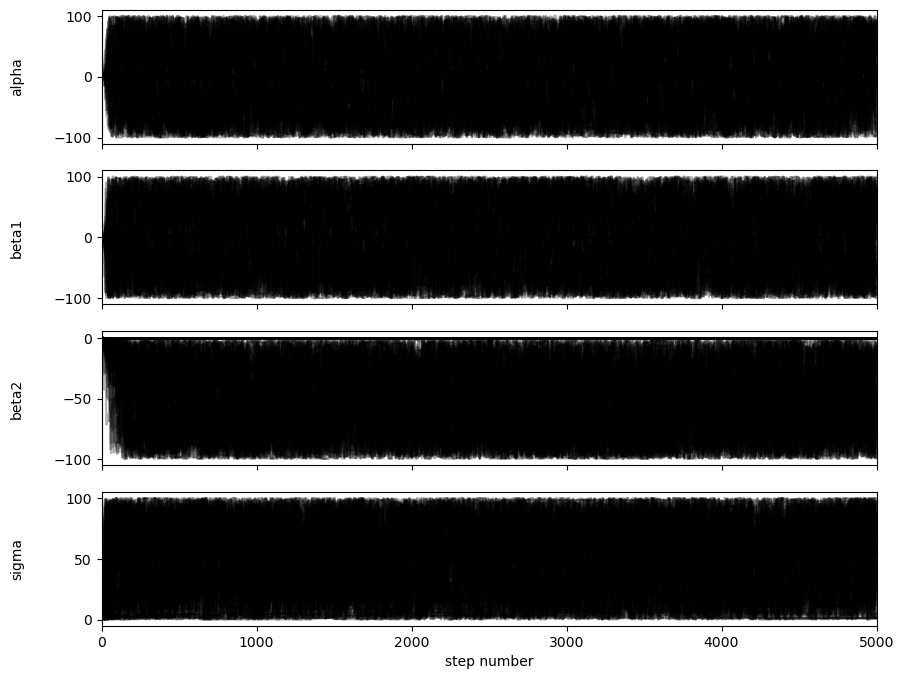

In [60]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta1", "beta2", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], samples, i, labels)

axes[-1].set_xlabel("step number")

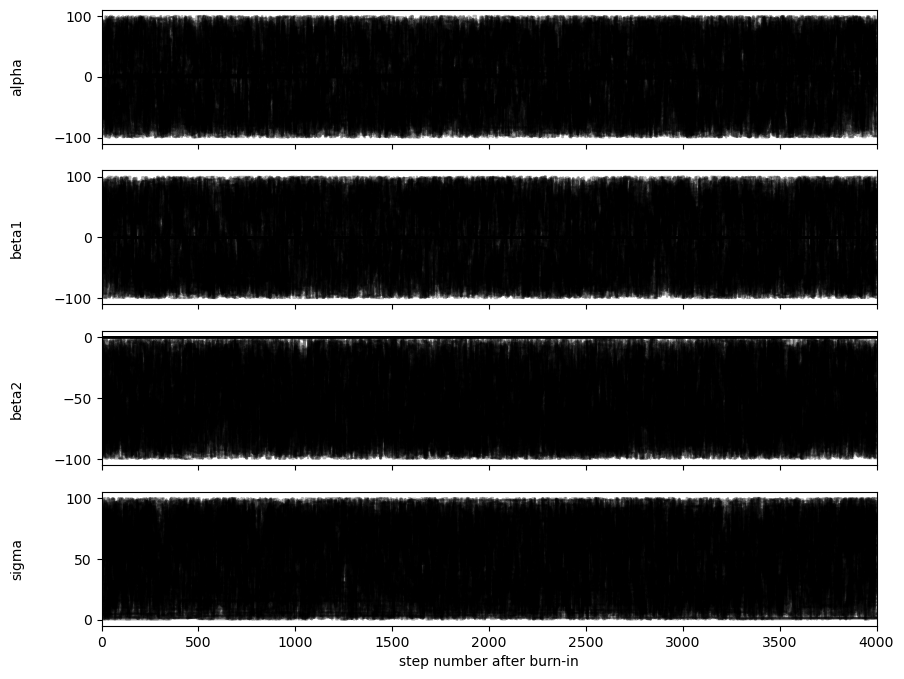

In [61]:
flat_samples = sampler.get_chain(discard=1000)

fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
labels = ["alpha", "beta1", "beta2", "sigma"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/day5/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (4000) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


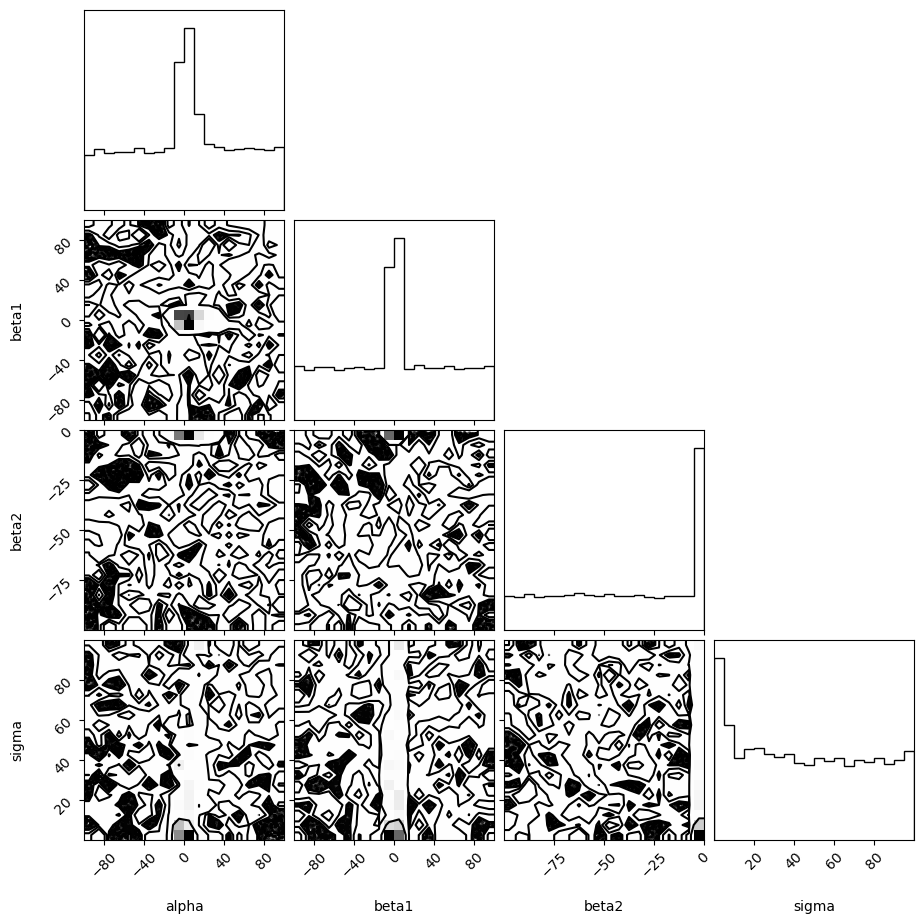

In [62]:
import corner

fig = corner.corner(flat_samples, labels=labels)

In [64]:
alpha = np.median(flat_samples[:,:, 0])
beta1 = np.median(flat_samples[:,:, 1])
beta2 = np.median(flat_samples[:,:, 2])
sigma = np.median(flat_samples[:,:, 3])

In [66]:
alpha + beta2 * 1150 + beta1 * mo['form'].iloc[-1]

-45651.73114270046

In [65]:
points_next = poisson.rvs(mu=alpha + beta2 * 1150 + beta1 * mo['form'].iloc[-1], size=1000)

fig, ax = plt.subplots()

ax.hist(points_next, bins=30, density=True, label='points_next')
ax.hist(mo['total_points'], bins=np.arange(0, 21), density=True, alpha=0.5, label='mo total_points')
ax.minorticks_on()
ax.tick_params(direction='in', which='both')
ax.legend()
ax.set_xlabel('Total Points')

plt.show()


ValueError: Domain error in arguments.

In [ ]:
#Poission likelihood